#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импортируем библиотеки и модули

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import time
import warnings

from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

### Загрузим данные из файла

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

### Уберем некритические предупреждения

In [3]:
warnings.filterwarnings('ignore')

### Убедимся, что данные расположены в хронологическом порядке

In [4]:
df.index.is_monotonic
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


### Рассемпелируем данные по 1 часу

In [5]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<AxesSubplot:xlabel='datetime'>

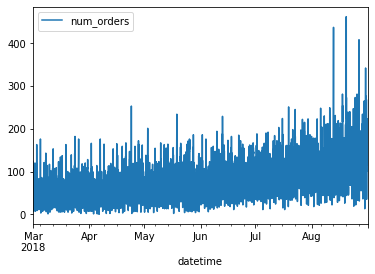

In [6]:
df.plot()

### Посмотрим на общую информацию о датасете

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


***Вывод***

В датасете 2 столбца "datetime" (дата и время заказа такси) и "num_orders" (количество заказов) - целевой признак. Число строк 4416. Пропуски в данных отсутствуют. Количество заказов имеет большие колебания.

## Анализ

### Посмотрим на графики "Тренда", "Сезонности" и "Ошибки"

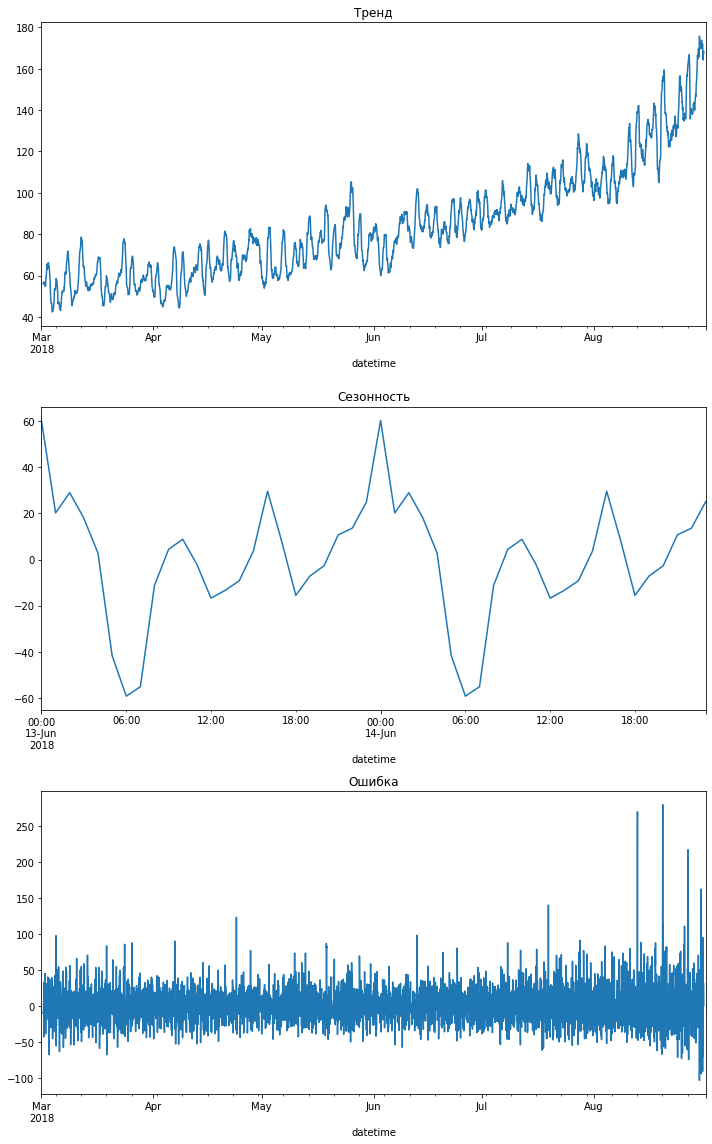

In [8]:
decompose = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(10, 16))
plt.subplot(311)

decompose.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)

decompose.seasonal['2018-06-13':'2018-06-14'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)

decompose.resid.plot(ax=plt.gca())
plt.title('Ошибка')

plt.tight_layout()

Данные имеют большие колебания

### Построим график 

<AxesSubplot:xlabel='datetime'>

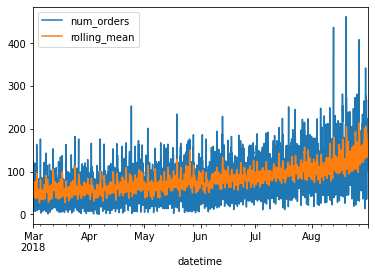

In [9]:
df['rolling_mean'] = df.rolling(10).mean()
df.plot()

***Вывод***

Из графиков видно, что присутствуют большие колебания. Тренд указывает на увеличение заказов. Сезоность показывает высокий спрос на такси в ночное время, из-за отсутствия общественного транспорта. Стохастический процесс нестационарный.

## Обучение

### Пропишим функцию для создания признаков

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()

### Применим функцию с лагом до 24 часов и 100-м скользящим средним

In [11]:
make_features(df, 24, 100)

### Удалим пропски и посмотрим на размер данных

In [12]:
df = df.dropna()
df.shape

(4316, 28)

### Построим график "Зависимость числа заказов от дней недели"

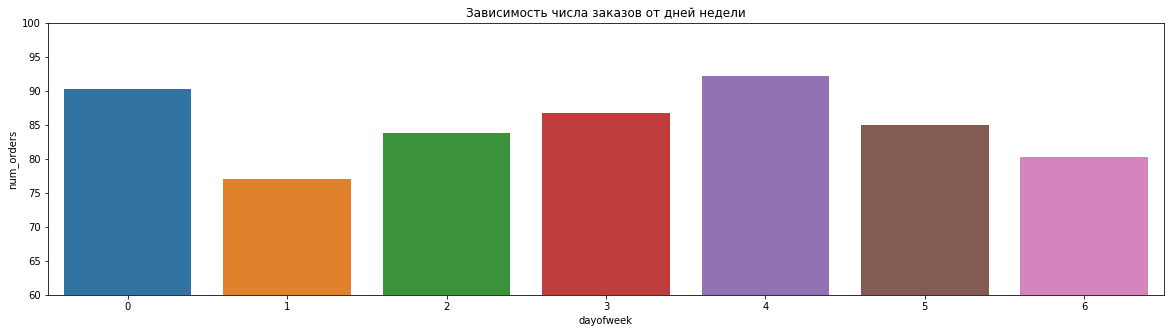

In [13]:
day_pivot = df.pivot_table(index=['dayofweek'],
                              values='num_orders',
                              aggfunc='mean')
plt.figure(figsize=(20,5))
sns.barplot(x='dayofweek', y='num_orders',
            data=day_pivot.reset_index())
plt.title('Зависимость числа заказов от дней недели')
plt.ylim(60, 100)
plt.show()

### Построим график "Зависимость числа заказов от часа"

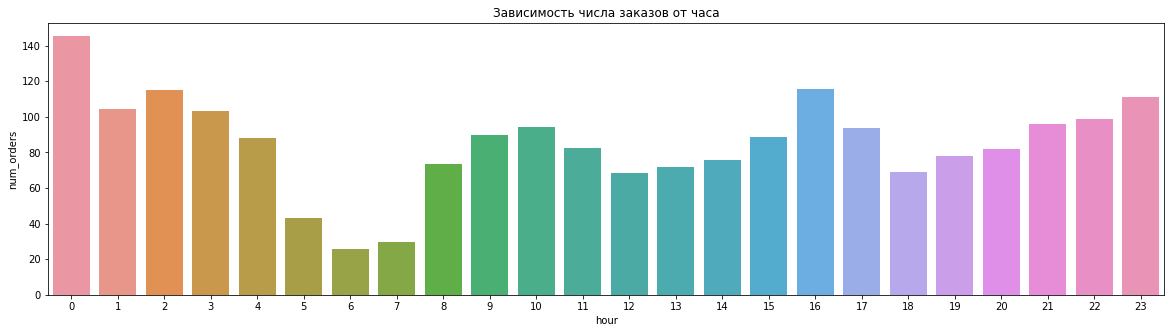

In [14]:
hour_pivot = df.pivot_table(index=['hour'],
                              values='num_orders',
                              aggfunc='mean')
plt.figure(figsize=(20,5))
sns.barplot(x='hour', y='num_orders',
            data=hour_pivot.reset_index())
plt.title('Зависимость числа заказов от часа')
plt.show()

### Разделим данные на обучающу и тестовую выборки

In [15]:
train,test = train_test_split(df,shuffle = False, random_state = 42, test_size = 0.2)
valid,test = train_test_split(test,shuffle = False, random_state = 42, test_size = 0.5)
train = train.dropna()
(train_features,
valid_features,
test_features) = (train.drop('num_orders',axis = 1),
                  valid.drop('num_orders',axis = 1),
                  test.drop('num_orders',axis = 1))
(train_target,
valid_target,
test_target) = (train['num_orders'],
                valid['num_orders'],
                test['num_orders'])

### Посмотрим на размеры выборок

In [16]:
print(train.shape, valid.shape, test.shape)

(3452, 28) (432, 28) (432, 28)


### DecisionTreeRegressor

In [17]:
%%time
splits = TimeSeriesSplit(n_splits=3)

dtr = DecisionTreeRegressor()
parametrs = {"max_depth": [1, 15, 2]}

grid_dtr = GridSearchCV(dtr,parametrs,cv = splits,verbose=True,n_jobs=None)
grid_dtr.fit(train_features,train_target)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
CPU times: user 182 ms, sys: 3.84 ms, total: 186 ms
Wall time: 189 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 15, 2]}, verbose=True)

### CatBoost

In [ ]:
%%time
splits = TimeSeriesSplit(n_splits=3)

catboost = CatBoostRegressor(loss_function='RMSE')
parameters_cat = {'depth':[1,10], 'learning_rate':np.arange(0.03, 0.1)}
grid_cat = catboost.grid_search(parameters_cat,
            Pool(train_features,train_target),cv=splits,verbose=100)

In [19]:
%%time
final_cat = CatBoostRegressor(depth=grid_cat["params"]["depth"], 
                              learning_rate=grid_cat["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(train_features,train_target))

0:	learn: 35.4390595	total: 896us	remaining: 895ms
100:	learn: 25.8923457	total: 67.5ms	remaining: 601ms
200:	learn: 24.2452599	total: 132ms	remaining: 523ms
300:	learn: 23.6406370	total: 194ms	remaining: 451ms
400:	learn: 23.2853800	total: 256ms	remaining: 382ms
500:	learn: 23.0340746	total: 321ms	remaining: 320ms
600:	learn: 22.8398066	total: 384ms	remaining: 255ms
700:	learn: 22.6858736	total: 460ms	remaining: 196ms
800:	learn: 22.5502182	total: 521ms	remaining: 129ms
900:	learn: 22.4277450	total: 581ms	remaining: 63.8ms
999:	learn: 22.3195163	total: 643ms	remaining: 0us
CPU times: user 716 ms, sys: 37.6 ms, total: 754 ms
Wall time: 1.45 s


### LinearRegression

In [20]:
%%time
my_cv = TimeSeriesSplit(n_splits=3).split(train_features)
model_lr = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
model_lr.fit(train_features, train_target)

CPU times: user 11.5 ms, sys: 184 µs, total: 11.7 ms
Wall time: 10.6 ms


LinearRegression(normalize=True)

### Произведем сравнение моделей

***DecisionTreeRegressor***

In [21]:
prediction_dtr_train = grid_dtr.best_estimator_.predict(train_features)
rmse_dtr_train = (mean_squared_error(train_target,prediction_dtr_train))**0.5

In [22]:
%%time
prediction_dtr_valid = grid_dtr.predict(valid_features)
rmse_dtr_valid = (mean_squared_error(valid_target,prediction_dtr_valid))**0.5

CPU times: user 13.7 ms, sys: 408 µs, total: 14.1 ms
Wall time: 2.72 ms


In [23]:
rmse_dtr_valid

45.621459978054375

***CatBoost***

In [24]:
prediction_cat_train = final_cat.predict(train_features)
rmse_cat_train = (mean_squared_error(train_target,prediction_cat_train))**0.5

In [25]:
%%time
prediction_cat_valid = final_cat.predict(valid_features)
rmse_cat_valid = (mean_squared_error(valid_target,prediction_cat_valid))**0.5

CPU times: user 3.81 ms, sys: 102 µs, total: 3.91 ms
Wall time: 3 ms


In [26]:
rmse_cat_valid

36.20598656621786

***LinearRegression***

In [27]:
prediction_lr_train = model_lr.predict(train_features)
rmse_lr_train = (mean_squared_error(train_target,prediction_lr_train))**0.5

In [28]:
%%time
prediction_lr_valid = model_lr.predict(valid_features)
rmse_lr_valid = (mean_squared_error(valid_target,prediction_lr_valid))**0.5

CPU times: user 6.29 ms, sys: 12.3 ms, total: 18.6 ms
Wall time: 8.39 ms


In [29]:
rmse_lr_valid

34.496874927395694

***Вывод***

Модели обучили, модели прошли валидацию, провели подбор гипперпараметров, подготовили модели к тестированию. Тестирование модели будем проводить на LinearRegression, так как она показала самое низкое значение RMSE на валидационной выборке (34.496874927395694).

## Тестирование

***LinearRegression***

In [59]:
%%time
test_start_time_lr = time.time()
prediction_lr_test = model_lr.predict(test_features)
test_total_time_lr = time.time() - test_start_time_lr

CPU times: user 2.84 ms, sys: 0 ns, total: 2.84 ms
Wall time: 2.17 ms


In [60]:
rmse_lr_test = (mean_squared_error(test_target,prediction_lr_test))**0.5

In [61]:
rmse_lr_test

45.54742100194132

### Подготовим данные для итоговой таблицы

In [62]:
report = pd.DataFrame(columns = ["DecisionTreeRegressor","CatBoost","LinearRegression"],
                      index = ["RMSE(train)",
                               "RMSE(valid)",
                               "RMSE(test)",
                               "Время обучения (секунды)",
                               "Время предсказания (секунды)"])


report.iloc[0] = [rmse_dtr_train,rmse_cat_train,rmse_lr_train]
report.iloc[1] = [rmse_dtr_valid,rmse_cat_valid,rmse_lr_valid]
report.iloc[2] = ["-","-",45.54742100194132]
report.iloc[3] = [0.0027,4.47,3.55]
report.iloc[4] = ["-","-",test_total_time_lr]

***Вывод***

In [63]:
display(report)

,DecisionTreeRegressor,CatBoost,LinearRegression
RMSE(train),27.563483,22.319516,24.56212
RMSE(valid),45.62146,36.205987,34.496875
RMSE(test),-,-,45.547421
Время обучения (секунды),0.0027,4.47,3.55
Время предсказания (секунды),-,-,0.002147


Наименьшее значение RMSE получено на модели LinearRegression. RMSE LinearRegression = 45.54742100194132. (По заданию это значение должно быть менее 48.) Так же можно отметить, что у модели LinearRegression самое короткое время обучения и время предсказания. 